<a href="https://colab.research.google.com/github/MamedenQ/OpenImagesDatasetDownloader/blob/master/OpenImagesDatasetDownloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.10.12


# 説明

このノートブックはGoogleOpenImagesDatasetからDLした画像とアノテーションファイル（BOX形式）を、YOLOv5,v8で読み込み可能なデータセットの形式に変換します。（セグメンテーション、リレーションシップには対応していません）

https://storage.googleapis.com/openimages/web/index.html

# 1.事前準備(設定項目もあるのでまとめて実行しないこと)



## ★ユーザ設定（実行者が設定）

In [2]:
# 内部処理用ルートフォルダ
root_folder = "/content/example"

# 最終的に出力されたYolo用の学習データセットをコピーする先のフォルダ
# train_data.zipが配置される
output_folder = "/content/drive/MyDrive/data/Colaboratory/openimages/datasets"

# 各クラスのバウンディングボックス数制限（100以上）
# （クラスによってはバウンディングボックスがやたら多い時もあるため）
# 制限をなくしたい場合、大きめの数字を指定すること
max_box_per_class = 2000

# train/validation/testの件数割合（合計で100になるよう設定）
# OpenImagesDatasetとしてのデータの配分は無視
# クラスによってばらつきがあるのと、自分で割合を決めたい場合もあるため
train_rate = 70
validation_rate = 20
test_rate = 10

チェック

In [3]:
if max_box_per_class < 100:
    raise Exception("各クラスのバウンディングボックス数制限が100ではありません")

if (train_rate + validation_rate + test_rate) != 100:
    raise Exception("train/validation/testの件数割合の合計が100ではありません")

## 内部処理用パス定義

In [4]:
# 関連ファイルフォルダ
meta_folder = root_folder + "/meta"
# 中間ファイル出力先フォルダ
temp_folder = root_folder + "/temp"
# 学習データ出力先フォルダ
train_folder = root_folder + "/train_data"

# クラスとラベルの紐づきが記述されたファイル
box_class_name_file = meta_folder + "/oidv7-class-descriptions-boxable.csv"

# BOXアノテーションが記述されたファイル
train_box_annotations_file = meta_folder + "/oidv6-train-annotations-bbox.csv"
valid_box_annotations_file = meta_folder + "/validation-annotations-bbox.csv"
test_box_annotations_file = meta_folder + "/test-annotations-bbox.csv"

## GoogleDriveのマウント

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## フォルダの作成

In [6]:
!rm -rf {root_folder}
!rm -rf {output_folder}

!mkdir -p {meta_folder}
!mkdir -p {temp_folder}

!mkdir -p {train_folder}/train/images
!mkdir -p {train_folder}/train/labels
!mkdir -p {train_folder}/valid/images
!mkdir -p {train_folder}/valid/labels
!mkdir -p {train_folder}/test/images
!mkdir -p {train_folder}/test/labels
!mkdir -p {output_folder}

## メタデータ、アノテーションファイルのDL

https://storage.googleapis.com/openimages/web/download_v7.html

`Annotations and metadata`セクションにある下記ファイルをDLする。

- クラスとラベルの紐付きが記述されたファイル

Metadata－Boxable class namesをDL

https://storage.googleapis.com/openimages/v7/oidv7-class-descriptions-boxable.csv

- BOXアノテーションが記述されたファイル

Boxes－Train,Validation,TestをDL

https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-bbox.csv

https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv

https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv

In [7]:
# クラスとラベルの紐づきが記述されたファイル
!wget https://storage.googleapis.com/openimages/v7/oidv7-class-descriptions-boxable.csv
!mv oidv7-class-descriptions-boxable.csv {meta_folder}

# BOXアノテーションが記述されたファイル（Train）
!wget https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-bbox.csv
!mv oidv6-train-annotations-bbox.csv {meta_folder}

# BOXアノテーションが記述されたファイル（Validation）
!wget https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv
!mv validation-annotations-bbox.csv {meta_folder}

# BOXアノテーションが記述されたファイル（Test）
!wget https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv
!mv test-annotations-bbox.csv {meta_folder}

import os

if not os.path.isfile(box_class_name_file):
    raise Exception("クラスとラベルの紐づきが記述されたファイルが存在しません。")
if not os.path.isfile(train_box_annotations_file):
    raise Exception("BOXアノテーションが記述されたファイル（訓練用）が存在しません。")
if not os.path.isfile(valid_box_annotations_file):
    raise Exception("BOXアノテーションが記述されたファイル（検証用）が存在しません。")
if not os.path.isfile(test_box_annotations_file):
    raise Exception("BOXアノテーションが記述されたファイル（テスト用）が存在しません。")

--2024-01-01 02:14:09--  https://storage.googleapis.com/openimages/v7/oidv7-class-descriptions-boxable.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.183.207, 173.194.193.207, 173.194.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.183.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12064 (12K) [text/csv]
Saving to: ‘oidv7-class-descriptions-boxable.csv’

oidv7-class-descrip 100%[===================>]  11.78K  --.-KB/s    in 0s      

2024-01-01 02:14:09 (46.5 MB/s) - ‘oidv7-class-descriptions-boxable.csv’ saved [12064/12064]

--2024-01-01 02:14:09--  https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.183.207, 173.194.193.207, 173.194.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.183.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225844759

## ★学習対象のラベルを設定（実行者が設定）

学習対象のクラスからラベルを特定する。

特定したラベルは次のセクションのコードに設定する。

1.クラスとラベルの紐づきが記述されたファイルの中身を出力

In [8]:
import pandas as pd

df = pd.read_csv(box_class_name_file, header=None)
df

,0,1
0,LabelName,DisplayName
1,/m/0mkg,Accordion
2,/m/03m3vtv,Adhesive tape
3,/m/0k5j,Aircraft
4,/m/046dlr,Alarm clock
...,...,...
597,/m/01dy8n,Woodpecker
598,/m/084hf,Worm
599,/m/01j5ks,Wrench
600,/m/0898b,Zebra


2.出力結果にある表の右上の丸いグリッドアイコンをクリック

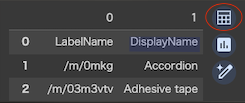

3.`Filter`ボタンをクリック

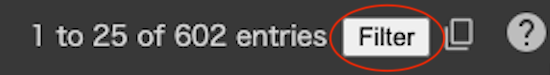

4.クラス名をフィルタ（画像①箇所）し、ラベル名（画像②箇所）をクリップボード等にコピーし控える

複数ある場合は複数控えておく

例）クラス名Ballであれば/m/018xmがラベル名称

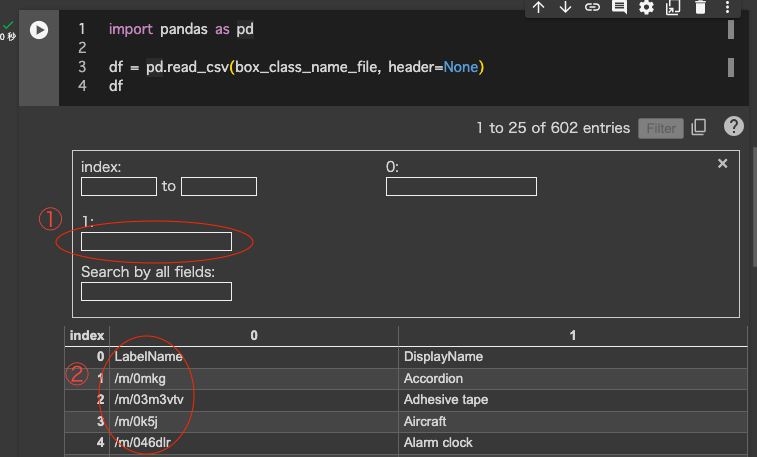

5.特定した学習対象ラベルを設定

`label_name`変数に特定したラベルを設定する。

`label_name_identifier`変数にクラス名を設定する。

対象ラベルが1つの場合においてもリスト形式とすること。

それぞれの変数のに設定するラベルとクラス名は、同じインデックスで対応させること。
（`label_name`リストの1番目にBallのラベルを設定した場合、`label_name_identifier`リストの1番目にもBallのクラス名を設定する）

In [9]:
# ラベル名
label_name = ["/m/018xm", "	/m/0k1tl"]

# クラス名（後続のセクションで利用）
label_name_identifier = ["Ball", "Pen"]

# 2. アノテーションリスト作成

## train

（時間がかかります）対象クラスに絞り込んだアノテーションリストを作成

In [10]:
import pandas as pd

df = pd.read_csv(train_box_annotations_file)
df = df.query("LabelName in {}".format(label_name))

print(len(df))
df.head()

df.to_csv(temp_folder + "/train.csv", index=False)

6845


確認

In [11]:
import pandas as pd

csv_path = temp_folder + "/train.csv"
df = pd.read_csv(csv_path)
print(len(df))
df

6845


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,00006685513e6bc4,xclick,/m/018xm,1,0.428125,0.450000,0.332423,0.361566,0,0,...,0,0,0.438750,0.450000,0.438750,0.428125,0.332423,0.350638,0.361566,0.348816
1,000819fd2a0433a9,xclick,/m/018xm,1,0.076667,0.183333,0.964375,0.999375,0,1,...,0,0,0.076667,0.135833,0.180833,0.183333,0.998750,0.964375,0.988750,0.999375
2,000f234939e98c68,xclick,/m/018xm,1,0.552067,0.585758,0.570000,0.612500,1,0,...,0,0,0.554364,0.558959,0.585758,0.552067,0.612500,0.570000,0.588750,0.597500
3,000f31e71b56641e,xclick,/m/018xm,1,0.564375,0.580625,0.906191,0.928705,0,0,...,0,0,0.564375,0.570625,0.580625,0.573125,0.923077,0.906191,0.913696,0.928705
4,00114337b89792cc,xclick,/m/018xm,1,0.625704,0.651032,0.928750,0.947500,0,0,...,0,0,0.633208,0.651032,0.638837,0.625704,0.928750,0.935625,0.947500,0.938750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840,ff6036e6771c1e20,xclick,/m/018xm,1,0.364375,0.484375,0.563333,0.720833,1,0,...,0,0,0.425000,0.484375,0.423750,0.364375,0.563333,0.665000,0.720833,0.640833
6841,ff95b5e9614b22a4,xclick,/m/018xm,1,0.193750,0.336250,0.762162,0.980180,1,0,...,0,0,0.193750,0.266875,0.336250,0.270625,0.880180,0.762162,0.869369,0.980180
6842,ffbb37b1cd2db49f,xclick,/m/018xm,1,0.150094,0.290807,0.565000,0.662500,1,0,...,0,0,0.150094,0.206379,0.290807,0.240150,0.597500,0.565000,0.603750,0.662500
6843,ffc7ab8a217d7680,xclick,/m/018xm,1,0.351875,0.388125,0.564103,0.613616,0,0,...,0,0,0.351875,0.373750,0.388125,0.377500,0.593280,0.564103,0.595049,0.613616


## validation

対象クラスに絞り込んだアノテーションリストを作成

In [12]:
import pandas as pd

df = pd.read_csv(valid_box_annotations_file)
df = df.query("LabelName in {}".format(label_name))

print(len(df))
df.head()

df.to_csv(temp_folder + "/validation.csv", index=False)

343


確認

In [13]:
import pandas as pd

csv_path = temp_folder + "/validation.csv"
df = pd.read_csv(csv_path)
print(len(df))
df

343


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,0052ea56ee869426,xclick,/m/018xm,1,0.000000,0.337500,0.033333,0.835417,0,1,0,0,0
1,0052ea56ee869426,xclick,/m/018xm,1,0.526563,0.848437,0.229167,0.658333,0,0,0,0,0
2,01eeeccf29b85fa0,xclick,/m/018xm,1,0.343750,0.951562,0.079167,0.881250,0,0,0,0,0
3,022caa5e84da4026,xclick,/m/018xm,1,0.345029,0.387427,0.162946,0.223214,1,0,0,0,0
4,02760ace01bd113f,xclick,/m/018xm,1,0.000000,1.000000,0.000000,1.000000,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,fb3fed6d3c8c3276,xclick,/m/018xm,1,0.228125,0.301563,0.116667,0.218750,0,0,0,0,0
339,fb3fed6d3c8c3276,xclick,/m/018xm,1,0.485938,0.515625,0.152083,0.193750,0,0,0,0,0
340,fb3fed6d3c8c3276,xclick,/m/018xm,1,0.768750,0.934375,0.260417,0.477083,0,0,0,0,0
341,fd1150844d3a7732,xclick,/m/018xm,1,0.408555,0.532448,0.561947,0.745575,1,0,0,0,0


## test

対象クラスに絞り込んだアノテーションリストを作成

In [14]:
import pandas as pd

df = pd.read_csv(test_box_annotations_file)
df = df.query("LabelName in {}".format(label_name))

print(len(df))
df.head()

df.to_csv(temp_folder + "/test.csv", index=False)

1299


確認

In [15]:
import pandas as pd

csv_path = temp_folder + "/test.csv"
df = pd.read_csv(csv_path)
print(len(df))
df

1299


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,0003d84e0165d630,xclick,/m/018xm,1,0.000000,0.198437,0.666667,0.941667,0,0,0,0,0
1,00156ac2ee0c3d58,xclick,/m/018xm,1,0.549337,0.639175,0.188053,0.336283,0,0,0,0,0
2,0141852d2feb21c6,xclick,/m/018xm,1,0.227468,0.630901,0.289294,0.662870,0,0,1,0,0
3,01e260e2d519a7ec,xclick,/m/018xm,1,0.101562,0.771875,0.422917,0.735417,0,0,1,0,0
4,01fa0e46ed41783e,xclick,/m/018xm,1,0.070312,0.356250,0.579167,0.766667,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294,ffea1b30f38a85ec,xclick,/m/018xm,1,0.000000,0.132841,0.382301,0.610619,0,1,0,0,0
1295,ffea1b30f38a85ec,xclick,/m/018xm,1,0.123616,0.302583,0.446018,0.656637,1,0,0,0,0
1296,ffea1b30f38a85ec,xclick,/m/018xm,1,0.197417,0.455720,0.454867,0.711504,0,0,0,0,0
1297,ffea1b30f38a85ec,xclick,/m/018xm,1,0.450184,0.651292,0.038938,0.231858,1,0,0,0,0


# 3. データセット作成

## data.yaml作成

In [16]:
import yaml

obj = {
    "train": "train/images",
    "val": "valid/images",
    "test": "test/images",
    "nc": len(label_name_identifier),
    "names": label_name_identifier
}

print(yaml.dump(obj))

with open(train_folder + "/data.yaml", "w") as file:
    yaml.dump(obj, file)

names:
- Ball
- Pen
nc: 2
test: train_data/test/images
train: train_data/train/images
val: train_data/valid/images



## アノテーションファイルをクラス別の最大ラベル数に従い再生成

In [17]:
import math
import pandas as pd

df_train = pd.read_csv(temp_folder + "/train.csv")
df_train["dl_image"] = "train/" + df_train["ImageID"]

df_validation = pd.read_csv(temp_folder + "/validation.csv")
df_validation["dl_image"] = "validation/" + df_validation["ImageID"]

df_test = pd.read_csv(temp_folder + "/test.csv")
df_test["dl_image"] = "test/" + df_test["ImageID"]

df_join = df_train.append(df_validation, ignore_index=True)
df_join = df_join.append(df_test, ignore_index=True)

# 全データ数
print(f"total:{len(df_join)}")

df_train_dl_list = pd.DataFrame(columns=df_train.columns)
df_validation_dl_list = pd.DataFrame(columns=df_train.columns)
df_test_dl_list = pd.DataFrame(columns=df_train.columns)

# ラベルを検索して最大数分確保する
for identifier, label in zip(label_name_identifier, label_name):
    print(f"identifier:{identifier} label:{label}")

    # query label
    df_query = df_join.query(f"LabelName == '{label}'")

    max_label = min(max_box_per_class, len(df_query))
    train_cnt = math.floor(max_label * train_rate / 100)
    validation_cnt = math.floor(max_label * validation_rate / 100)
    test_cnt = max_label - (train_cnt + validation_cnt)
    print(f"max_box_per_class:{max_box_per_class} max_label:{max_label} train_cnt:{train_cnt} validation_cnt:{validation_cnt} test_cnt:{test_cnt}")

    # train
    df_train_label = df_query.iloc[0:train_cnt, :]
    df_train_dl_list = df_train_dl_list.append(df_train_label)

    # valid
    df_validation_label = df_query.iloc[train_cnt:train_cnt + validation_cnt, :]
    df_validation_dl_list = df_validation_dl_list.append(df_validation_label)

    # test
    df_test_label = df_query.iloc[train_cnt + validation_cnt:train_cnt + validation_cnt + test_cnt, :]
    df_test_dl_list = df_test_dl_list.append(df_test_label)

print(f"df_train_dl_list:{len(df_train_dl_list)} df_validation_dl_list:{len(df_validation_dl_list)} df_test_dl_list:{len(df_test_dl_list)}")

# 絞り込んだアノテーションリストを保存
df_train_dl_list.to_csv(temp_folder + "/train_query.csv", index=False)
df_validation_dl_list.to_csv(temp_folder + "/validation_query.csv", index=False)
df_test_dl_list.to_csv(temp_folder + "/test_query.csv", index=False)

df_train_dl_list = df_train_dl_list.loc[:][["dl_image"]]
df_train_dl_list = df_train_dl_list.drop_duplicates()
df_validation_dl_list = df_validation_dl_list.loc[:][["dl_image"]]
df_validation_dl_list = df_validation_dl_list.drop_duplicates()
df_test_dl_list = df_test_dl_list.loc[:][["dl_image"]]
df_test_dl_list = df_test_dl_list.drop_duplicates()

print(f"df_train_dl_list:{len(df_train_dl_list)} df_validation_dl_list:{len(df_validation_dl_list)} df_test_dl_list:{len(df_test_dl_list)}")

# ダウンロードリストを保存
df_train_dl_list.to_csv(temp_folder + "/train_dl_list.txt", header=False, index=False)
df_validation_dl_list.to_csv(temp_folder + "/validation_dl_list.txt", header=False, index=False)
df_test_dl_list.to_csv(temp_folder + "/test_dl_list.txt", header=False, index=False)

total:8487
identifier:Ball label:/m/018xm
max_box_per_class:2000 max_label:2000 train_cnt:1400 validation_cnt:400 test_cnt:200
identifier:Pen label:	/m/0k1tl
max_box_per_class:2000 max_label:0 train_cnt:0 validation_cnt:0 test_cnt:0
df_train_dl_list:1400 df_validation_dl_list:400 df_test_dl_list:200
df_train_dl_list:666 df_validation_dl_list:230 df_test_dl_list:103


<ipython-input-17-190fd22e0294>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_join = df_train.append(df_validation, ignore_index=True)
<ipython-input-17-190fd22e0294>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_join = df_join.append(df_test, ignore_index=True)
<ipython-input-17-190fd22e0294>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train_dl_list = df_train_dl_list.append(df_train_label)
<ipython-input-17-190fd22e0294>:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_validation_dl_list = df_validation_dl_list.append(df_validation_label)
<ipython-input-17-190fd22e0294>:46: FutureWarning: The frame.append me

## 画像DL

In [18]:
!wget https://raw.githubusercontent.com/openimages/dataset/master/downloader.py
!pip3 install boto3

--2024-01-01 02:15:13--  https://raw.githubusercontent.com/openimages/dataset/master/downloader.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4244 (4.1K) [text/plain]
Saving to: ‘downloader.py’

downloader.py       100%[===================>]   4.14K  --.-KB/s    in 0s      

2024-01-01 02:15:13 (17.4 MB/s) - ‘downloader.py’ saved [4244/4244]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.9 MB/s eta 0:00:00


In [19]:
!python downloader.py "{temp_folder}/train_dl_list.txt" --download_folder="{train_folder}/train/images" --num_processes=20
!python downloader.py "{temp_folder}/validation_dl_list.txt" --download_folder="{train_folder}/valid/images" --num_processes=20
!python downloader.py "{temp_folder}/test_dl_list.txt" --download_folder="{train_folder}/test/images" --num_processes=20

## アノテーションファイル作成

In [20]:
import pandas as pd
import cv2
import math
import os

train_csv_path = temp_folder + "/train_query.csv"
df_train = pd.read_csv(train_csv_path)

valid_csv_path = temp_folder + "/validation_query.csv"
df_validation = pd.read_csv(valid_csv_path)

test_csv_path = temp_folder + "/test_query.csv"
df_test = pd.read_csv(test_csv_path)

# print(len(df_train))
# print(df_train)
def write_bbox(kind, df):
    for idx, label in enumerate(label_name):
        df_query_label = df.query("LabelName == '" + label + "'")
        # print(f"{kind} label:{label} len:{len(df)}")
        for i, row in enumerate(df_query_label.itertuples()):
            xmin = row.XMin
            xmax = row.XMax
            ymin = row.YMin
            ymax = row.YMax

            width = xmax - xmin
            center_x = xmin + width / 2
            height = ymax - ymin
            center_y = ymin + height / 2

            with open(f"{train_folder}/{kind}/labels/{row.ImageID}.txt", "a") as f:
                f.write(f"{idx} {center_x} {center_y} {width} {height}\n")

write_bbox("train", df_train)
write_bbox("valid", df_validation)
write_bbox("test", df_test)

## 圧縮、コピー

In [21]:
%cd {root_folder}
!zip train_data -r train_data
!cp train_data.zip "{root_folder}"
%cd /content

/content/example
  adding: train_data/ (stored 0%)
  adding: train_data/test/ (stored 0%)
  adding: train_data/test/labels/ (stored 0%)
  adding: train_data/test/labels/3b0e8c298b056c63.txt (deflated 32%)
  adding: train_data/test/labels/3d9c4c212d217bd1.txt (deflated 35%)
  adding: train_data/test/labels/3cd5e3213dfd1cf2.txt (deflated 22%)
  adding: train_data/test/labels/3c9b8ff5fef4d6c0.txt (deflated 38%)
  adding: train_data/test/labels/3dae78a1b88f5a0e.txt (deflated 38%)
  adding: train_data/test/labels/396bb7b81a7dd7c2.txt (deflated 39%)
  adding: train_data/test/labels/3bde7c6145591ad2.txt (deflated 24%)
  adding: train_data/test/labels/3bee0a9e29a773d6.txt (deflated 25%)
  adding: train_data/test/labels/3d3e0054bca15961.txt (deflated 32%)
  adding: train_data/test/labels/3aead45203a4f38f.txt (deflated 32%)
  adding: train_data/test/labels/3af6f90486691282.txt (deflated 51%)
  adding: train_data/test/labels/3eed705a2b994064.txt (deflated 43%)
  adding: train_data/test/labels/38e

## GoogleDriveへコピー

In [22]:
!cp {root_folder}/train_data.zip {output_folder}